In [1]:
import numpy as np
import uproot as up
import pandas as pd
import matplotlib.pyplot as plot
from scipy.stats import norm
from scipy.optimize import curve_fit
import sympy
from IPython.display import clear_output
import math
import time
import util
#My imports
from util import PVect,get_layer,create_layer_map,theta_func,phi_func,findBin,bin_percent_theta_phi

In [2]:
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata
import torch.optim as optim

from tqdm import tqdm

In [3]:
#roc-curve calculations
from sklearn.metrics import roc_auc_score, roc_curve

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [6]:
particle = "mu"
energy = "5"
color_dict = {
    "pi" : "red",
    "mu" : "blue"
}
part_dict = {
    -211 : 1,
    13 : 0
}

Input:
1. \# hits per layer
2. total energy per layer

56 total

In [245]:
def p_func(x,y,z):
    return np.sqrt((x ** 2) + (y ** 2) + (z ** 2))

In [156]:
def calculate_num_pixels(energy_dep):
    efficiency = 0.005
    return 10 * energy_dep * (1000 * 1000) * efficiency

In [260]:
def create_data_depth(uproot_path, file_num = 0, particle = "pion"):
    events = up.open(uproot_path)

    x_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.x"].array(library='np')
    EDep_branch = events["HcalBarrelHits.EDep"].array(library='np')
    Hits_MC_idx_branch = events["_HcalBarrelHits_MCParticle.index"].array(library='np')
    PDG_branch = events["MCParticles.PDG"].array(library='np')

    x_momentum_branch = events["MCParticles.momentum.x"].array(library='np')
    y_momentum_branch = events["MCParticles.momentum.y"].array(library='np')
    z_momentum_branch = events["MCParticles.momentum.z"].array(library='np')
    num_events = len(x_pos_branch)
    num_features = 56
    num_layers = 28

    hits_per_layer = np.zeros((num_events,28))
    EDep_per_layer = np.zeros((num_events,28))
    label = np.zeros((num_events,1))
    layers_traversed = np.zeros((num_events,1))
    primary_momentum = np.zeros((num_events,1))
    skip_count = 0
    for event_idx in range(len(x_pos_branch)):
        if(not event_idx % (len(x_pos_branch) // 10)):
            clear_output(wait = True)
            print(f"on event #{event_idx} for file #{file_num} for {particle}")
        event_x_pos = x_pos_branch[event_idx]
        event_EDep = EDep_branch[event_idx]
        
        current_px = x_momentum_branch[event_idx][0]
        current_py = y_momentum_branch[event_idx][0]
        current_pz = z_momentum_branch[event_idx][0]

        primary_momentum[event_idx][0] = p_func(current_pz,current_py,current_pz)
        #for each event, loop over the particles to find mu/pi
        hit_layers = np.zeros(28)
        for hit_idx in range(len(event_x_pos)):
            current_x_pos = event_x_pos[hit_idx]
            current_EDep = event_EDep[hit_idx]

            layer_hit = get_layer(current_x_pos,super_layer_map)
            if(layer_hit == -1):
                skip_count += 1
                continue
            hit_layers[layer_hit] += 1
            EDep_per_layer[event_idx][layer_hit] += current_EDep
            hits_per_layer[event_idx][layer_hit] += 1
        label[event_idx][0] = part_dict[PDG_branch[event_idx][0]]
        for i in range(29):
            if(i == 28):
                layers_traversed[event_idx][0] = 28
            elif(hit_layers[i] < 2):
                if(i == 0):
                    layers_traversed[event_idx][0] = 0
                else:
                    layers_traversed[event_idx][0] = i
    return torch.cat((torch.tensor(EDep_per_layer),torch.tensor(primary_momentum),torch.tensor(layers_traversed),torch.tensor(label)),1)
#     return torch.cat((torch.tensor(hits_per_layer),torch.tensor(EDep_per_layer),torch.tensor(primary_momentum),torch.tensor(label)),1)


In [246]:
def create_data(uproot_path, file_num = 0, particle = "pion"):
    events = up.open(uproot_path)

    x_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.x"].array(library='np')
    EDep_branch = events["HcalBarrelHits.EDep"].array(library='np')
    Hits_MC_idx_branch = events["_HcalBarrelHits_MCParticle.index"].array(library='np')
    PDG_branch = events["MCParticles.PDG"].array(library='np')

    x_momentum_branch = events["MCParticles.momentum.x"].array(library='np')
    y_momentum_branch = events["MCParticles.momentum.y"].array(library='np')
    z_momentum_branch = events["MCParticles.momentum.z"].array(library='np')
    num_events = len(x_pos_branch)
    num_features = 56
    num_layers = 28

    hits_per_layer = np.zeros((num_events,28))
    EDep_per_layer = np.zeros((num_events,28))
    label = np.zeros((num_events,1))
    primary_momentum = np.zeros((num_events,1))
    skip_count = 0
    for event_idx in range(len(x_pos_branch)):
        if(not event_idx % (len(x_pos_branch) // 10)):
            clear_output(wait = True)
            print(f"on event #{event_idx} for file #{file_num} for {particle}")
        event_x_pos = x_pos_branch[event_idx]
        event_EDep = EDep_branch[event_idx]
        
        current_px = x_momentum_branch[event_idx][0]
        current_py = y_momentum_branch[event_idx][0]
        current_pz = z_momentum_branch[event_idx][0]

        primary_momentum[event_idx][0] = p_func(current_pz,current_py,current_pz)
        #for each event, loop over the particles to find mu/pi
        for hit_idx in range(len(event_x_pos)):
            current_x_pos = event_x_pos[hit_idx]
            current_EDep = event_EDep[hit_idx]

            layer_hit = get_layer(current_x_pos,super_layer_map)
            if(layer_hit == -1):
                skip_count += 1
                continue
            EDep_per_layer[event_idx][layer_hit] += current_EDep
            hits_per_layer[event_idx][layer_hit] += 1
        label[event_idx][0] = part_dict[PDG_branch[event_idx][0]]
    return torch.cat((torch.tensor(EDep_per_layer),torch.tensor(primary_momentum),torch.tensor(label)),1)
#     return torch.cat((torch.tensor(hits_per_layer),torch.tensor(EDep_per_layer),torch.tensor(primary_momentum),torch.tensor(label)),1)


In [247]:
layer_map, super_layer_map = create_layer_map()

In [263]:
for i in range(10,14):
    if(i == 10):
        mu_data = create_data_depth(uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/mu/variation_10kevents_file_{i}.edm4hep.root:events",file_num = i, particle = "muon")
        pi_data = create_data_depth(uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/pi/variation_10kevents_file_{i}.edm4hep.root:events",file_num=i,particle="pion")
    else:
        add_mu = create_data_depth(uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/mu/variation_10kevents_file_{i}.edm4hep.root:events",file_num = i, particle = "muon")
        mu_data = torch.cat((mu_data, add_mu),0)
        add_pi = create_data_depth(uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/pi/variation_10kevents_file_{i}.edm4hep.root:events",file_num=i,particle="pion")
        pi_data = torch.cat((pi_data, add_pi),0)
for i in range(14,15):
    if(i == 14):
        test_mu_data = create_data_depth(uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/mu/variation_10kevents_file_{i}.edm4hep.root:events",file_num = i, particle = "muon")
        test_pi_data = create_data_depth(uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/pi/variation_10kevents_file_{i}.edm4hep.root:events",file_num=i,particle="pion")
    else:
        test_add_mu = create_data_depth(uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/mu/variation_10kevents_file_{i}.edm4hep.root:events",file_num = i, particle = "muon")
        test_mu_data = torch.cat((test_mu_data, test_add_mu),0)
        test_add_pi = create_data_depth(uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/pi/variation_10kevents_file_{i}.edm4hep.root:events",file_num=i,particle="pion")
        test_pi_data = torch.cat((test_pi_data, test_add_pi),0)

on event #9000 for file #14 for pion


In [264]:
dataset = torch.cat((mu_data,pi_data),)
indexes = torch.randperm(dataset.shape[0])
dataset_shuffled = dataset[indexes]

test_dataset = torch.cat((test_mu_data,test_pi_data),)
test_indexes = torch.randperm(test_dataset.shape[0])
test_dataset_shuffled = test_dataset[test_indexes]

In [265]:
class Classifier(nn.Module):
    """
    Classifier for normalized tensors
    """
    def __init__(self, input_size=29, num_classes=2, hidden_dim = 256, num_layers = 5):
        super(Classifier, self).__init__()
        self.layer = nn.Sequential()
        for i in range(num_layers):
            if(i == 0):
                self.layer.append(
                nn.Linear(input_size, hidden_dim)
                )
                self.layer.append(
                    nn.ReLU(inplace=True)
                )
            elif(i == num_layers - 1):
                self.layer.append(
                nn.Linear(hidden_dim, num_classes)
                )
            else:
                self.layer.append(
                    nn.Linear(hidden_dim, hidden_dim)
                )
                self.layer.append(
                    nn.ReLU(inplace=True)
                )
        self.name = "Classifier"
        self.double()
        
    def forward(self, h):
        c = self.layer(h)
        return c
    
    # @property
    def name(self):
        """
        Name of model.
        """
        return self.name

In [268]:
classifier = Classifier(num_layers = 10, input_size=30).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4, weight_decay=1e-5)
num_epochs_classifier = 15

In [269]:
train_data = dataset_shuffled

num_epochs = 1
batch_size = 100
num_it = train_data.shape[0] // batch_size

show_progress = True
loss_hist = []
curr_losses = []
for i in range(num_epochs):
    epoch_hist = np.array([])
    val_epoch_hist = np.array([])
    with tqdm(total=num_it, position=0, leave=True) as pbar:
        for it in range(num_it):
            optimizer.zero_grad()
            #randomly sample the latent space
            begin = it * batch_size
            end = (it + 1) * batch_size
            it_data = train_data[begin:end]
            samples = it_data[:,:30]
            labels = it_data[:,30]#.unsqueeze(1)
#             print(labels)
            samples = samples.to(device)
            labels = (labels.type(torch.LongTensor)).to(device)
            # forward + backward + optimize
            outputs = classifier(samples)
#             print(outputs)
            loss = criterion(outputs, labels)
            # Do backprop and optimizer step
            if ~(torch.isnan(loss) | torch.isinf(loss)):
                loss.backward()
                optimizer.step()
            # Log loss
            if~(torch.isnan(loss)):
                curr_losses.append(loss.to('cpu').data.numpy())
                if(not (it % 5)):
                    loss_hist.append(sum(curr_losses) / len(curr_losses))
                    curr_losses = []
            if(show_progress):
                pbar.update(1)

print('Finished Training')

100%|██████████| 800/800 [00:03<00:00, 202.72it/s]

Finished Training


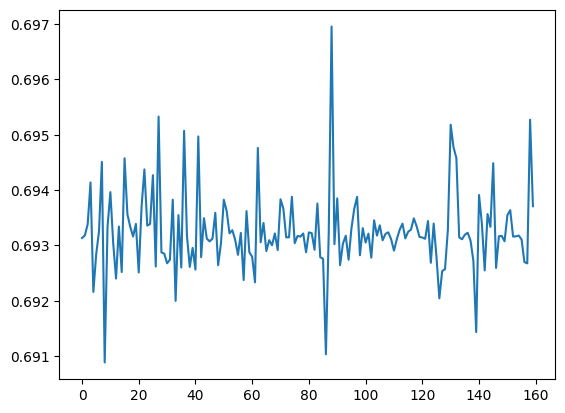

In [270]:
plot.plot(loss_hist)

In [271]:
test_data = test_dataset_shuffled
# test_data = dataset_shuffled

In [272]:
test_batch_size = 10
test_num_it = test_data.shape[0] // test_batch_size

In [273]:
outputs = torch.empty(test_data.shape[0],2)    
with tqdm(total=test_num_it, position=0, leave=True) as pbar:
    for it in range(test_num_it):
        #randomly sample the latent space
        begin = it * test_batch_size
        end = (it + 1) * test_batch_size
        it_data = test_data[begin:end]
        samples = it_data[:,:30]
        labels = it_data[:,30]#.unsqueeze(1)
        samples = samples.to(device)
        labels = (labels.type(torch.LongTensor)).to(device)
        # forward + backward + optimize
        output_batch = classifier(samples)
        for i in range(test_batch_size):
            outputs[it*test_batch_size + i] = output_batch[i]
        if(show_progress):
            pbar.update(1)

100%|██████████| 2000/2000 [00:02<00:00, 870.82it/s]


In [274]:
test_Y     = test_data[:,30].clone().detach().float().view(-1, 1).to("cpu")
probs_Y = torch.softmax(outputs, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1,1)
test_acc = (test_Y == argmax_Y.float()).sum().item() / len(test_Y)
print(f"Accuracy: {test_acc * 100}")  

Accuracy: 50.0


AUC = 0.5000


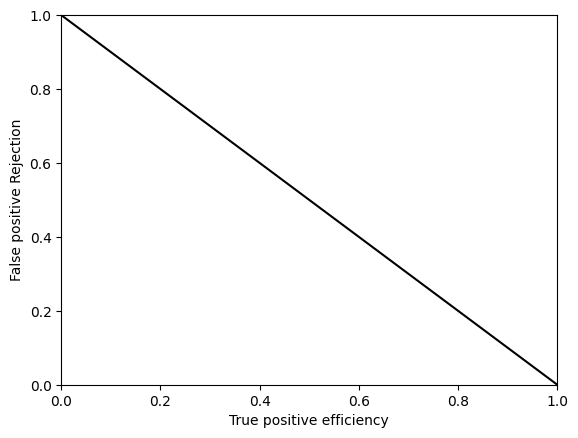

In [275]:
verbose = True
# Get ROC curve
pfn_fp, pfn_tp, threshs = roc_curve(test_Y, probs_Y[:,1].detach().numpy())

auc = roc_auc_score(np.squeeze(test_Y), probs_Y[:,1].detach().numpy())
print(f'AUC = {auc:.4f}')
f = plot.figure()

plot.plot(pfn_tp, 1-pfn_fp, '-', color='black')

# axes labels
plot.xlabel('True positive efficiency')
plot.ylabel('False positive Rejection')

# axes limits
plot.xlim(0, 1)
plot.ylim(0, 1)

f.show()

In [ ]:
def find_layer_traversed():
    num_pixels_per_layer = 
    for i in range(28):
        if (num_pixels_per_layer[i] < 2):
            return i - 1